<a href="https://colab.research.google.com/github/akilawickey/IT-5437/blob/main/Assignment1_IT5437.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

#Basic helper methods
def imread_gray(path):
    """Read as 8-bit grayscale [0..255]."""
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Cannot read: {path}")
    return img

def apply_lut(img, lut_1d):
    """Apply 256-entry lookup table to an 8-bit image."""
    lut = np.asarray(lut_1d, dtype=np.uint8)
    return cv2.LUT(img, lut)

def piecewise_lut(points):
    """
    Build a 256-length LUT from piecewise-linear control points.
    points: list of (x_in, y_out) with 0<=x_in<=255 and 0<=y_out<=255,
            sorted by x_in, can include intentional 'jumps' (same x twice).
    """
    xs, ys = zip(*points)
    xs, ys = np.array(xs, float), np.array(ys, float)

    lut = np.zeros(256, float)
    i = 0
    while i < len(xs) - 1:
        x0, y0 = xs[i], ys[i]
        x1, y1 = xs[i+1], ys[i+1]

        # handle vertical jump (same x twice)
        if x1 == x0:
            lut[int(x0)] = y0
            i += 1
            continue

        # linear segment
        m = (y1 - y0) / (x1 - x0)
        x_range = np.arange(int(np.ceil(x0)), int(np.floor(x1)) + 1)
        lut[x_range] = m * (x_range - x0) + y0
        i += 1

    # fill left/right ends and clamp
    lut[:int(xs[0])] = ys[0]
    lut[int(xs[-1]):] = ys[-1]
    lut = np.clip(lut, 0, 255).astype(np.uint8)
    return lut

def show_img(title, img):
    plt.figure(figsize=(5,5))
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.title(title); plt.axis('off'); plt.show()

def show_hist(img, title="Histogram"):
    plt.figure(figsize=(5,3))
    plt.hist(img.ravel(), bins=256, range=(0,255))
    plt.title(title); plt.xlabel("Intensity"); plt.ylabel("Count")
    plt.show()

def show_mapping(lut, title="Intensity transform"):
    plt.figure(figsize=(5,4))
    x = np.arange(256)
    plt.plot(x, lut)
    plt.title(title); plt.xlabel("Input intensity"); plt.ylabel("Output intensity")
    plt.xlim(0,255); plt.ylim(0,255); plt.grid(True, alpha=.3)
    plt.show()

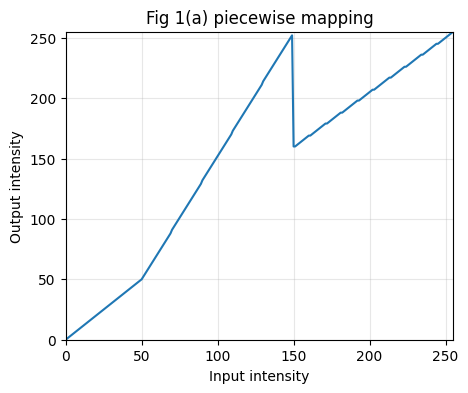

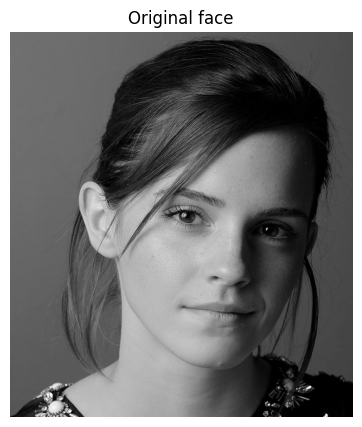

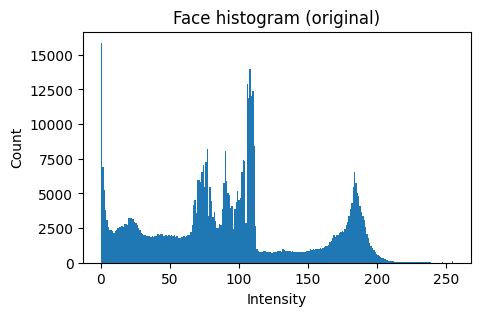

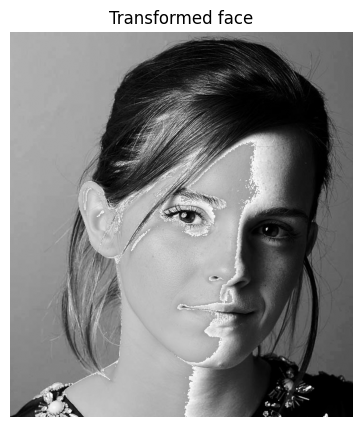

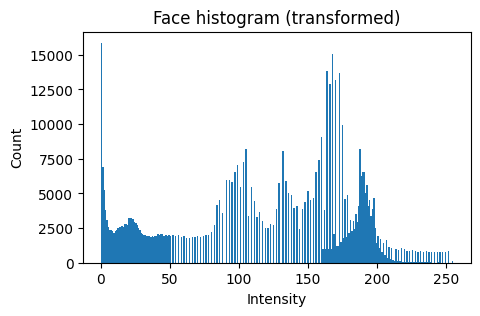

In [4]:
# Q1

im = cv2.imread('/content/drive/MyDrive/cv images/emma.jpg')
assert im is not None

points_q1 = [(0,0), (50,50), (150,255), (150,160), (255,255)]
lut_q1 = piecewise_lut(points_q1)

show_mapping(lut_q1, title="Fig 1(a) piecewise mapping")

# image file load
face_path = "/content/drive/MyDrive/cv images/emma.jpg"
face = imread_gray(face_path)
show_img("Original face", face)
show_hist(face, "Face histogram (original)")

# transform
face_t = apply_lut(face, lut_q1)
show_img("Transformed face", face_t)
show_hist(face_t, "Face histogram (transformed)")

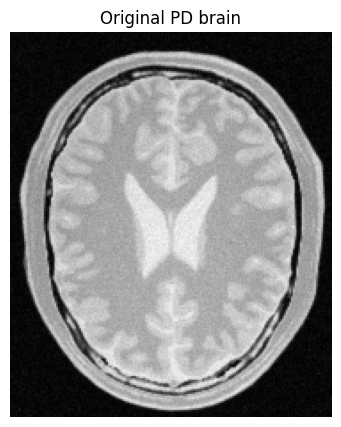

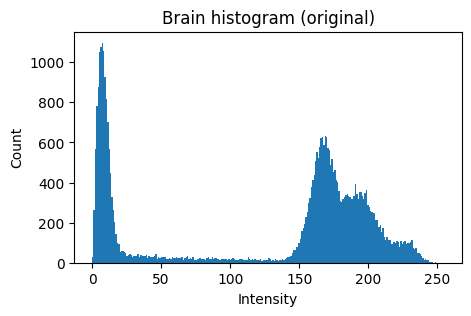

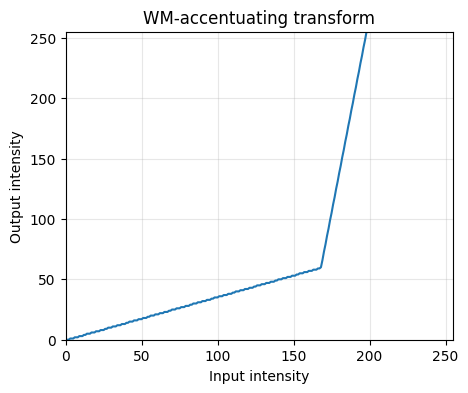

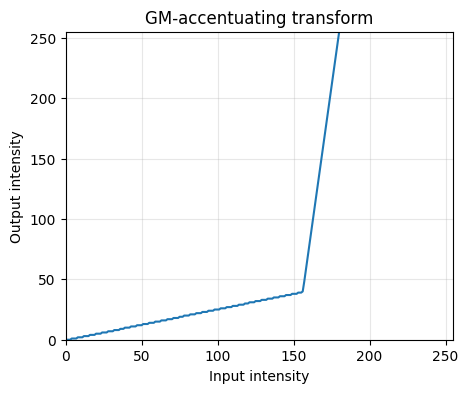

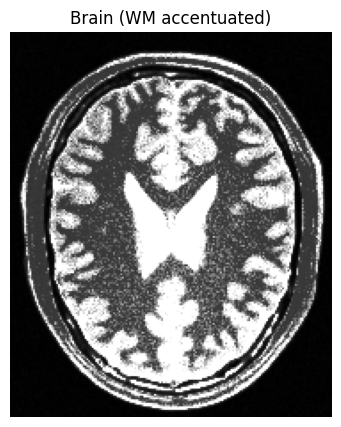

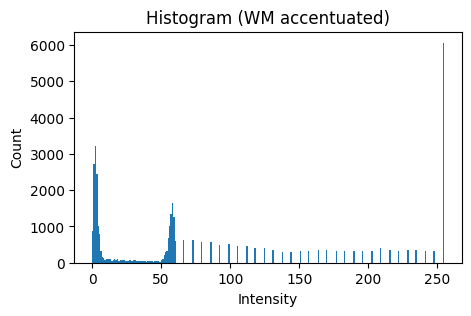

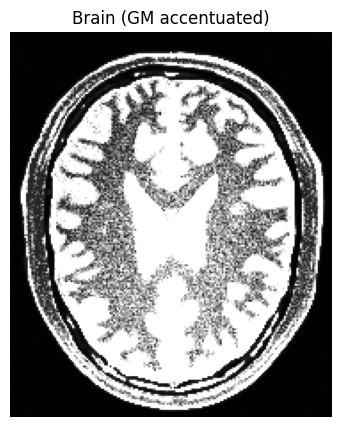

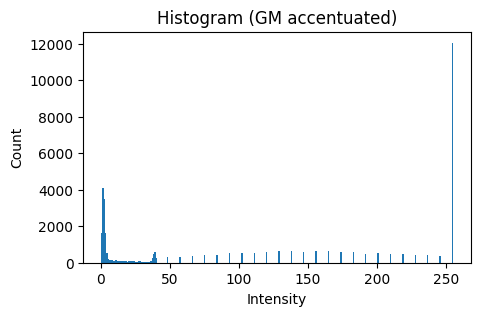

In [8]:
#Q2

brain_path = "/content/drive/MyDrive/cv images/brain_proton_density_slice.png"
brain = imread_gray(brain_path)
show_img("Original PD brain", brain)
show_hist(brain, "Brain histogram (original)")

# --- derive windows from percentiles (tweak if needed) ---
p = np.percentile(brain, [10, 25, 40, 55, 70, 85, 95])
p10, p25, p40, p55, p70, p85, p95 = p

G1, G2 = p40, p70   # gray-matter window ~ mid intensities
W1, W2 = p55, p85   # white-matter window ~ higher mids

# ---- White matter accentuating mapping ----
# strong emphasis between [W1,W2], compress below
wm_points = [(0, 0), (int(W1), 60), (int(W2), 255), (255, 255)]
lut_wm = piecewise_lut(wm_points)

# ---- Gray matter accentuating mapping ----
# strong emphasis between [G1,G2], compress outside
gm_points = [(0, 0), (int(G1), 40), (int(G2), 255), (255, 255)]
lut_gm = piecewise_lut(gm_points)

# Plot mappings
show_mapping(lut_wm, "White matter accentuating transform")
show_mapping(lut_gm, "Gray matter accentuating transform")

# Apply
brain_wm = apply_lut(brain, lut_wm)
brain_gm = apply_lut(brain, lut_gm)

# results
show_img("Brain (WM accentuated)", brain_wm)
show_hist(brain_wm, "Histogram (WM accentuated)")
show_img("Brain (GM accentuated)", brain_gm)
show_hist(brain_gm, "Histogram (GM accentuated)")